## 1 - We filter down the style clusters to the most relevant ones.

The relevant clusters are those who have a higher probability to contain quality articles than other. To filter down these, we simply compute $P(N_j|Q = 1)$ i.e. the probability of the node $j$ given that we have a quality article 

To obtain this we simply compute

$$
\begin{align*}
P(N_j | Q ) &= \frac{P(Q | N_j) P(N_j)}{\sum_i P(Q |N_i)P(N_i)}
\end{align*}
$$

where 
* $P(Q | N_j)$ is given by the number of articles of quality in the node $N_j$ over the number of articles in the node $N_j$ (or $N_i$).
* $P(N_j)$ is given by the probability that an article belong to the node $N_j$ 

If $P(N_j | Q) > \frac{1}{|N|}$ *i.e.* the probability of an article to belong to the cluster $N_j$ is higher than by randomly selecting a cluster, we consider this cluster to be more relevant than the others.

## 1.0 - Preprocessing

### 1.1 - Reading the data

In [2]:
import pandas as pd 
import numpy as np 

path_data = "data/"

df_style = pd.read_parquet(path_data+"df_style.parquet")
df_topic = pd.read_parquet(path_data+"df_topic.gzip.parquet")


In [3]:
import joblib 

dict_featured_articles = joblib.load(path_data+"dict_adq.joblib")
dict_good_articles = joblib.load(path_data+"dict_ba.joblib")


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from os.path import exists 

if not exists(path_data+"pipeline.joblib"):
    pipe = Pipeline([("scaler",StandardScaler()),
                     ("reduction",PCA(21)),
                     ("cluster", KMeans(191))])

    X = df_style.groupby(level=1).sample(5,replace=True).to_numpy()
    pipe.fit(X)

    joblib.dump(pipe,path_data+"pipeline.joblib")
else:
    pipe = joblib.load(path_data+"pipeline.joblib")

cluster_matrix = pipe["cluster"].cluster_centers_
print(pipe[:1])
X = pipe[:2].transform(df_style.to_numpy())
df_style = pd.DataFrame(data=X,
                        index=df_style.index, columns=list(range(X.shape[1])))

Pipeline(steps=[('scaler', StandardScaler())])


In [5]:
df_style.head()

,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
timestamp,titre,,,,,,,,,,,,,,,,,,,,,
2005-03-21 20:13:07+00:00,(1) Cérès,4.113225,-0.210338,-5.658188,-1.046304,0.904451,-0.426880,1.610331,3.277934,-1.129398,1.043513,0.436776,-0.930671,-1.672369,-1.212173,0.014285,-0.379388,0.780392,-0.836730,-1.398117,0.221378,-1.694586
2005-10-01 11:48:05+00:00,(1) Cérès,3.386910,0.553226,-5.276926,-1.178415,0.707697,-0.067574,1.328529,3.194228,-2.177607,0.962751,0.133235,-0.689534,-0.945160,-1.705037,-0.129201,0.521223,0.375750,-0.339907,-1.075002,0.394400,-1.850850
2005-10-13 10:50:30+00:00,(1) Cérès,3.082903,-0.014312,-4.687123,-0.081409,0.241139,-0.995823,1.107893,3.157688,-2.482341,0.299294,-0.298415,-0.150399,-1.022140,-1.249071,-0.209062,0.146599,0.075323,-0.143256,-0.838705,0.173355,-1.313243
2005-10-23 04:39:58+00:00,(1) Cérès,3.082903,-0.014312,-4.687123,-0.081409,0.241139,-0.995823,1.107893,3.157688,-2.482341,0.299294,-0.298415,-0.150399,-1.022140,-1.249071,-0.209062,0.146599,0.075323,-0.143256,-0.838705,0.173355,-1.313243
2005-11-08 10:33:30+00:00,(1) Cérès,4.125820,-0.179164,-5.609512,-1.878729,1.298362,-0.868625,2.197385,3.170403,-0.665055,1.589769,-0.022820,-0.674178,-1.933348,-0.465309,-0.975879,-0.217647,1.178551,-0.452369,-1.174655,0.552131,-1.741283


### 1.2 - Sort the relevant clusters

In [6]:
import itertools as itr 

#from functions.article_quality_functions import articles_to_qual_vect
from functions.category_vectorizer import filter_dataframe, relevant_cluster_identifier, articles_to_qual_vect
from tqdm import tqdm 

from scipy.stats import rankdata
from scipy.spatial.distance import cdist

relevant_clusters_mask = relevant_cluster_identifier(df_style,
                                                    cluster_matrix,
                                                    dict_good_articles,
                                                    dict_featured_articles)



30it [01:02,  2.07s/it]


### 1.3 - Get the final dataset

In [7]:
import numpy as np 

common_textes = set(df_style.index.get_level_values(1)).intersection(set(list(df_topic.index)))
df_style = df_style[df_style.index.get_level_values(1).isin(list(common_textes))]
df_topic = df_topic.loc[list(common_textes),:]

sampled_textes = df_style.groupby(level=1).sample(5, replace=True)
textes_names = sampled_textes.index.get_level_values(1)

from functions.category_vectorizer import vectorizer

# Transform the data into vectors representing the amount of articles belonging to a topic in a cluster at a given semester
VI = vectorizer(sampled_textes,
                df_topic=df_topic,
                cluster_matrix=cluster_matrix,
                relevant_nodes_mask=relevant_clusters_mask)


30it [00:02, 12.02it/s]


In [8]:
VI[VI["target"] != 0]

biography women food-and-drink  ... space technology target
2005 Jan.-June 1         0.0   0.0            0.0  ...   0.0        0.0    1.0
               2         1.0   0.0            0.0  ...   0.0        0.0    2.0
               7         1.0   0.0            0.0  ...   0.0        0.0    1.0
               15        0.0   0.0            0.0  ...   0.0        0.0    1.0
               30        1.0   0.0            0.0  ...   0.0        0.0    1.0
...                      ...   ...            ...  ...   ...        ...    ...
2019 July-Dec. 186       0.0   0.0            0.0  ...   1.0        1.0   42.0
               187       1.0   0.0            0.0  ...   0.0        0.0   16.0
               188       1.0   1.0            0.0  ...   1.0        1.0   72.0
               189       0.0   0.0            0.0  ...   0.0        0.0    4.0
               190       6.0   1.0            0.0  ...   0.0        0.0   35.0

[4621 rows x 65 columns]

In [9]:
clean_VI = VI[VI["target"] != 0]

X_VI = VI.iloc[:,:-1]
X_VD = VI.iloc[:,-1]


---

# 2 - Selection of the relevant topics

If we base ourselves on all the topics we have, we tend to overestimate the number of articles in a cluster at a given semester. This is because some articles possess multiple tags, thus one article is counted several time.

Selecting relevant topic mean selecting uncorrelated representative topics. Our aim is thus to find a minimal set of topic $\mathcal{C}$ such as :
$$
argmin \; y - \hat{y}
$$

with $y$ being the true number of articles in a node at a given semester and

$$
\hat{y} = \sum_C \beta_C N_{C,i}(t)
$$

With $N_{C,i}$ the number of articles belonging to the topic $C$ and the cluster $i$ at time $t$. And $\beta$ a coefficient found by a machine learning model.

Our point will then be to find a minimal size for the set $\mathcal{C}$ that is also minimizing the MSE.

---
First, well observe the performances of an estimator depending on the number of topic selected

100%|██████████| 100/100 [00:02<00:00, 40.94it/s]


Text(0.5, 1.0, 'Evolution of the reduction of the MAE of the baseline model depending on the number of topic selected')

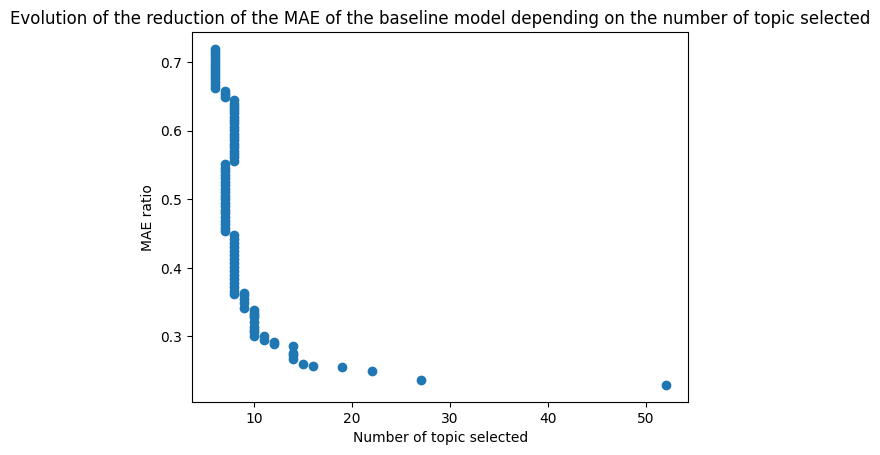

In [ ]:
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt 

X_train, X_test, y_train, y_test = train_test_split(X_VI,X_VD,train_size=0.7, shuffle=True)
scores = []
score_init = median_absolute_error(y_test, X_test.sum(1))
for i in tqdm(np.linspace(0.01,10,100)):
    lr_test = ElasticNet(alpha=i,l1_ratio=0.5)
    lr_test.fit(X_train,y_train)

    scores.append((sum(lr_test.coef_!=0),median_absolute_error(y_test, lr_test.predict(X_test))/score_init))

plt.scatter(x=[x[0] for x in scores],
            y=[x[1] for x in scores])

plt.xlabel("Number of topic selected")
plt.ylabel("MAE ratio")
plt.title("Evolution of the reduction of the MAE of the baseline model depending on the number of topic selected")

---

Then we try to optimize the parameters of our model but we'll penalize model with too much topics. For this, we just add a penalty that adds 2 point per topics.

In [30]:
from sklearn.metrics import mean_absolute_error, make_scorer

def mae_penalty_scorer(estimator, X, y, lambda_=4):
    # Predict on validation data
    y_pred = estimator.predict(X)
    # Compute MAE
    mae = mean_absolute_error(y, y_pred)

    # Get number of parameters (for linear models, use coef_.size; for trees, use estimator complexity)
    k = sum(estimator["model"].coef_ != 0)

    return mae + lambda_ * k

custom_scorer = make_scorer(
    mae_penalty_scorer,
    greater_is_better=False,  # Lower scores are better
    lambda_=2  # Pass penalty directly
)

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from scipy.stats import uniform, loguniform

def random_search(model_in, parameters, X,y ):

    clf = RandomizedSearchCV(model_in, parameters, random_state=291321, n_iter=100,scoring=mae_penalty_scorer,cv=50)
    search = clf.fit(X,y)
    return search

pipe = Pipeline([
        ("model",ElasticNet(positive=True))])
#search_orthogonal = random_search(OrthogonalMatchingPursuit(), dict(n_nonzero_coefs =  randint(5,30)), X, y)
search_elastic = random_search(pipe, dict(model__alpha = loguniform(1,10_000),
                                          model__l1_ratio = uniform(0.001, 0.999)), X_VI, X_VD)
                        

Let's now see what are our best parameters ! 

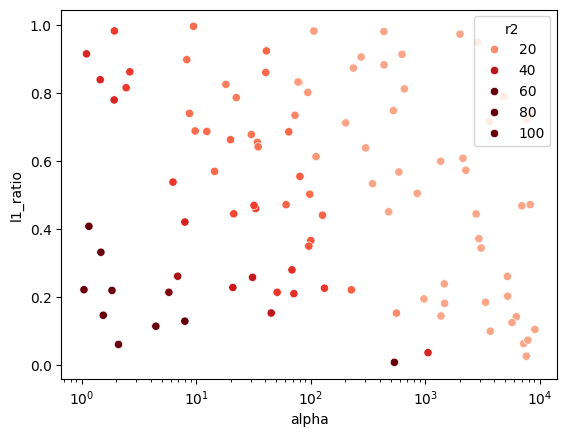

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 

resultats_elastic = search_elastic.cv_results_
x_axis, y_axis = [x["model__alpha"] for x in resultats_elastic["params"]], [x["model__l1_ratio"] for x in resultats_elastic["params"]]
heat, rank = resultats_elastic["mean_test_score"], 1/resultats_elastic["rank_test_score"]
df_plot = pd.DataFrame([[x,y,h,r] for (x,y,h,r) in zip(x_axis, y_axis, heat, rank)],
                       columns=["x","y","r2","rank"])


ax = sns.scatterplot(df_plot, x="x",y="y",hue='r2',palette="Reds", hue_order=(-1,1),hue_norm=(-0.5,50))
ax.set_xlabel("alpha")
ax.set_ylabel("l1_ratio")
ax.set(xscale="log")
#ax.set_xlim()

sns.move_legend(ax, "upper right")

plt.savefig("resultats_random_search_elastic_net_R2.png",dpi=500,bbox_inches="tight")

Let's now see how the model perform compared to the baseline

Text(0.5, 0, 'Predictions without topic selection and scaling')

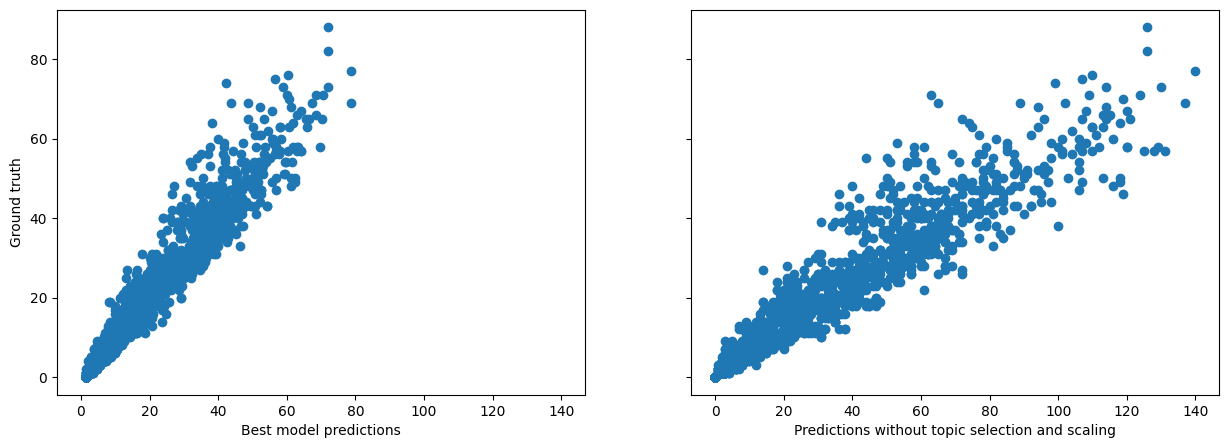

In [33]:
from sklearn.model_selection import train_test_split 

alpha, l1_ratio = search_elastic.best_params_["model__alpha"], search_elastic.best_params_["model__l1_ratio"]

lr = ElasticNet(alpha=alpha,
                l1_ratio=l1_ratio)

X_train, X_test, y_train, y_test = train_test_split(X_VI,X_VD,train_size=0.7, shuffle=True)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)
surrogate = X_test.sum(1)

fig, ax = plt.subplots(ncols=2,figsize=(15,5),sharex=True, sharey=True)

ax[0].scatter(predictions, y_test)
ax[1].scatter(surrogate, y_test)
ax[0].set_ylabel("Ground truth")
ax[0].set_xlabel("Best model predictions")
ax[1].set_xlabel("Predictions without topic selection and scaling")

Finally let's see the topic selected ! 

In [34]:
from pprint import pprint

cutoff = sum(search_elastic.best_estimator_["model"].coef_!=0)
sort_mask = np.argsort(search_elastic.best_estimator_["model"].coef_)
topics = df_topic.columns

pprint(topics[sort_mask][:cutoff])

Index(['south-america', 'education', 'business-and-economics',
       'central-africa', 'eastern-africa', 'northern-africa',
       'southern-africa', 'western-africa', 'society', 'central-america',
       'southern-europe', 'northern-europe', 'central-asia', 'east-asia',
       'north-asia', 'south-asia', 'southeast-asia', 'western-europe',
       'fashion', 'eastern-europe', 'architecture', 'women', 'food-and-drink',
       'internet-culture', 'physics', 'medicine-and-health'],
      dtype='object')
